# Preprocessing

In [1]:
import seaborn as sns
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
# import pytorch_lightning as pl


from transformers import (
    AdamW,
    MT5ForConditionalGeneration,
    T5ForConditionalGeneration,
    T5TokenizerFast,
    AutoTokenizer,
    PreTrainedTokenizerFast,
    T5ForTokenClassification,
    RobertaTokenizerFast,
    AutoModelForTokenClassification,
    get_linear_schedule_with_warmup
)

label2id = {'O': 0, 'B-ALG': 1, 'I-ALG': 2, 'B-APP': 3, 'I-APP': 4, 'B-CB': 5, 'I-CB': 6, 'B-CLA': 7, 'I-CLA': 8, 'B-DEV': 9, 'I-DEV': 10, 'B-DS': 11, 'I-DS': 12, 'B-DT': 13, 'I-DT': 14, 'B-FN': 15, 'I-FN': 16, 'B-FT': 17, 'I-FT': 18, 'B-FUN': 19, 'I-FUN': 20, 'B-HXT': 21, 'I-HXT': 22, 'B-LAN': 23, 'I-LAN': 24, 'B-LIB': 25, 'I-LIB': 26, 'B-OS': 27, 'I-OS': 28, 'B-UIE': 29, 'I-UIE': 30, 'B-UN': 31, 'I-UN': 32, 'B-VAL': 33, 'I-VAL': 34, 'B-VAR': 35, 'I-VAR': 36, 'B-VER': 37, 'I-VER': 38, 'B-WEB': 39, 'I-WEB': 40}
id2label = {label2id[x]: x for x in label2id}
labels = ['Algorithm', 'Application', 'Class', 'Code_Block', 'Data_Structure', 'Data_Type', 'Device', 'File_Name', 'File_Type', 'Function', 'HTML_XML_Tag', 'Language', 'Library', 'Operating_System', 'User_Interface_Element', 'User_Name', 'Value', 'Variable', 'Version', 'Website']
labels_short = ['ALG', 'APP', 'CB', 'CLA', 'DEV', 'DS', 'DT', 'FN', 'FT', 'FUN', 'HXT', 'LAN', 'LIB', 'OS', 'UIE', 'UN', 'VAL', 'VAR', 'VER', 'WEB']
short2long = {'ALG': 'Algorithm', 'APP': 'Application', 'CB': 'Class', 'CLA': 'Code_Block', 'DEV': 'Data_Structure', 'DS': 'Data_Type', 'DT': 'Device', 'FN': 'File_Name', 'FT': 'File_Type', 'FUN': 'Function', 'HXT': 'HTML_XML_Tag', 'LAN': 'Language', 'LIB': 'Library', 'OS': 'Operating_System', 'UIE': 'User_Interface_Element', 'UN': 'User_Name', 'VAL': 'Value', 'VAR': 'Variable', 'VER': 'Version', 'WEB': 'Website'}

path_save_image = "../figs/"

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abuboba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from datasets import load_dataset
import datasets
datasets.builder.has_sufficient_disk_space = lambda needed_bytes, directory='.': True


path = "../data/StackOverflow/json/"

dataset = load_dataset('json', data_files=os.path.join(path, 'data_train.json'))
dataset["test"] = load_dataset('json', data_files=os.path.join(path, 'data_test.json'))["train"]
dataset["validation"] = load_dataset('json', data_files=os.path.join(path, 'data_dev.json'))["train"]


In [3]:
model_code_name = "Salesforce/codet5-small"
tokenizer_code = RobertaTokenizerFast.from_pretrained(model_code_name, add_prefix_space=True)
model_code = AutoModelForTokenClassification.from_pretrained(
    "../checkpoints/codet5-small-token-clf/checkpoint-11580", num_labels=len(label2id), id2label=id2label, label2id=label2id, device_map='cuda:0'
)

model_name = "t5-small"
tokenizer = T5TokenizerFast.from_pretrained(model_name)
model = T5ForTokenClassification.from_pretrained(
    "../checkpoints/t5-small-token-clf/checkpoint-11580", num_labels=len(label2id), id2label=id2label, label2id=label2id, device_map='cuda:0'
)#.to("cuda")

In [4]:
def tokenize_and_align_labels(examples, tokenizer):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [5]:
tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True, fn_kwargs={"tokenizer": tokenizer})
tokenized_dataset_code = dataset.map(tokenize_and_align_labels, batched=True, fn_kwargs={"tokenizer": tokenizer_code})

# Results

In [6]:
import numpy as np
import evaluate

seqeval = evaluate.load("seqeval")
label_list = list(label2id.keys())

def compute_metrics(p, full=False):
    predictions, labels = p

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    if full:
        return results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

## Validation set

In [7]:
pred = []
pred_code = []
for item in tokenized_dataset["validation"]:
    a = tokenizer(item["tokens"],truncation=True, padding=True,is_split_into_words=True, return_tensors="pt").to("cuda")
    predictions = np.argmax(model(**a).logits.cpu().detach(), axis=2)
    pred.extend(predictions)


for item in tokenized_dataset_code["validation"]:
    a = tokenizer_code(item["tokens"],truncation=True, padding=True,is_split_into_words=True, return_tensors="pt").to("cuda")
    predictions = np.argmax(model_code(**a).logits.cpu().detach(), axis=2)
    pred_code.extend(predictions)

dct = compute_metrics((pred, tokenized_dataset["validation"]["labels"]), True)
dct_code = compute_metrics((pred_code, tokenized_dataset_code["validation"]["labels"]), True)

C:\Users\abuboba\.conda\envs\Assignment1_PMLDL\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


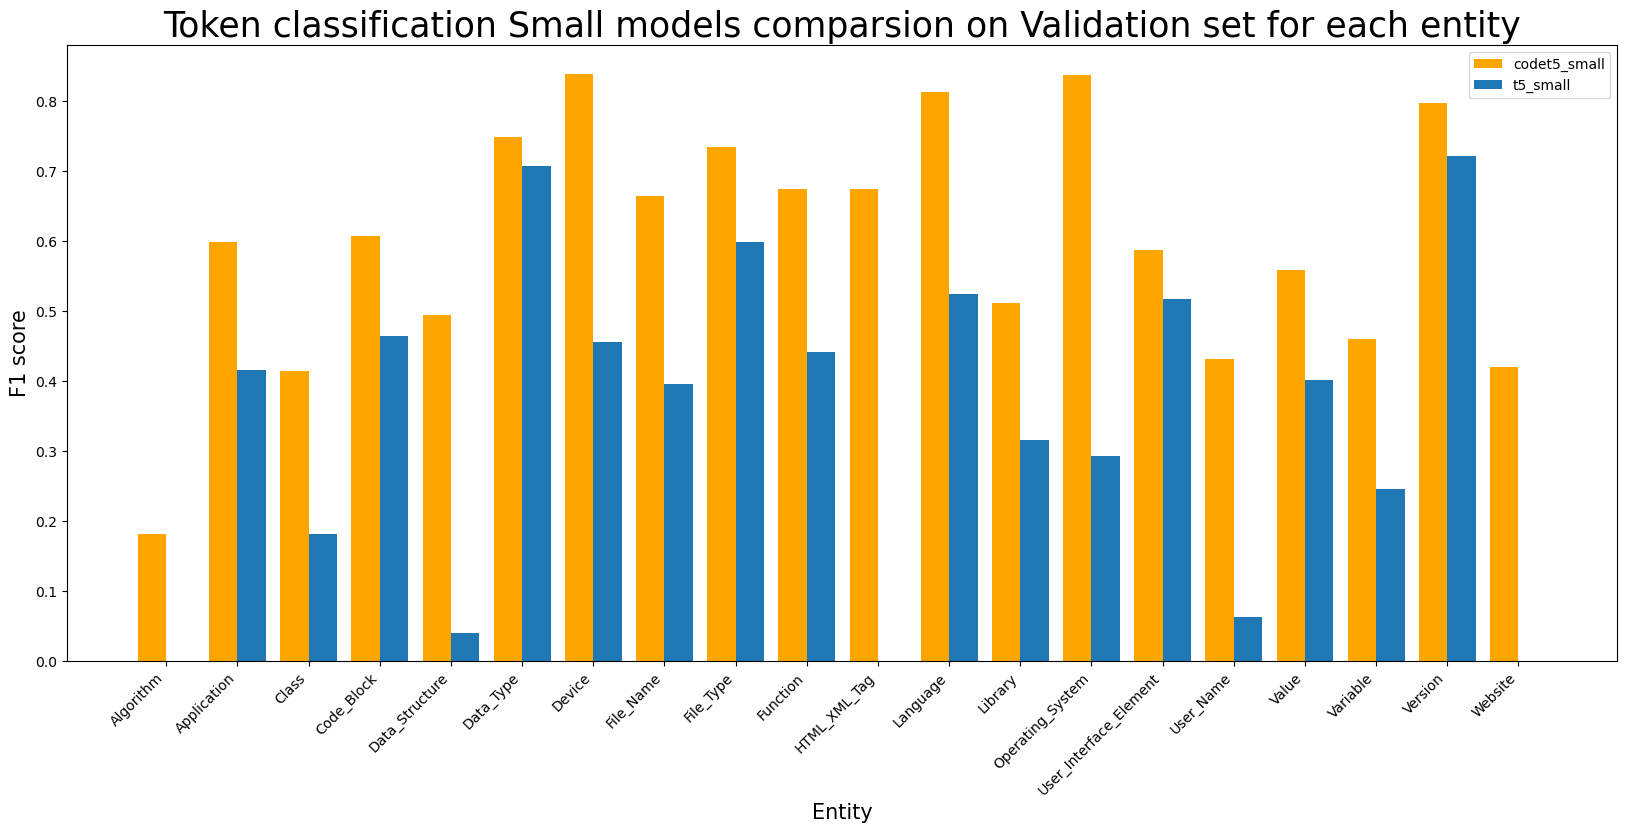

In [8]:
import matplotlib.pyplot as plt

barWidth = 0.2
fig = plt.subplots(figsize =(20, 8))

dct_arr = {x: dct[x]["f1"] for x in dct if "overall" not in x}
dct_arr_code = {x: dct_code[x]["f1"] for x in dct_code if "overall" not in x}

X = [short2long[x] for x in dct_arr.keys()]
X_axis = np.arange(len(X))

plt.bar(X_axis - barWidth, list(dct_arr_code.values()), color="orange", width=barWidth*2, label ='codet5_small')
plt.bar(X_axis + barWidth, list(dct_arr.values()),  width=barWidth*2, label ='t5_small')

plt.title('Token classification Small models comparsion on Validation set for each entity', fontsize = 25)
plt.xlabel('Entity', fontsize = 15)
plt.ylabel('F1 score', fontsize = 15) 
plt.xticks(X_axis, X, rotation=45, ha='right')
plt.legend()
plt.savefig(path_save_image + 'plot_small_0.png')
plt.show()


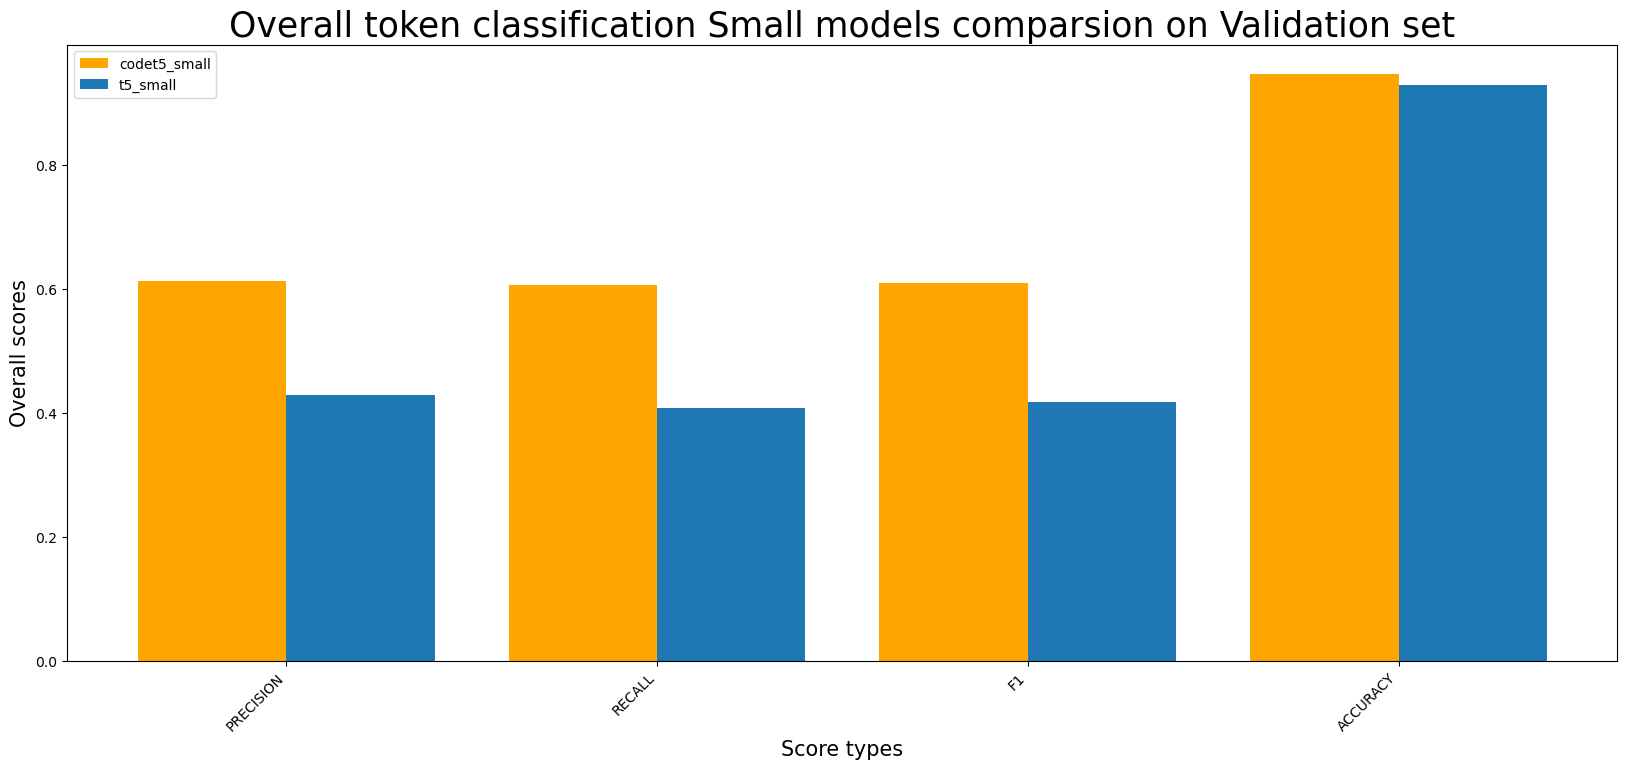

In [9]:
import matplotlib.pyplot as plt

barWidth = 0.2
fig = plt.subplots(figsize =(20, 8))

dct_arr = {x: dct[x] for x in dct if "overall" in x}
dct_arr_code = {x: dct_code[x] for x in dct_code if "overall" in x}

X = [x.split("_")[1].upper() for x in dct_arr.keys() if "overall" in x]
X_axis = np.arange(len(X))

plt.bar(X_axis - barWidth, list(dct_arr_code.values()), color="orange", width=barWidth*2, label="codet5_small")
plt.bar(X_axis + barWidth, list(dct_arr.values()),  width=barWidth*2, label="t5_small")

plt.title('Overall token classification Small models comparsion on Validation set', fontsize = 25)
plt.xlabel('Score types', fontsize = 15)
plt.ylabel('Overall scores', fontsize = 15) 
plt.xticks(X_axis, X, rotation=45, ha='right')
plt.legend()
plt.savefig(path_save_image + 'plot_small_1.png')
plt.show()


In [10]:
print(f"F1 scores on VALIDATION set:\n\n{model_name} - {dct['overall_f1']}\n{model_code_name} - {dct_code['overall_f1']}")

F1 scores on VALIDATION set:

t5-small - 0.4178938594053903
Salesforce/codet5-small - 0.6097161572052402


## Test set

In [11]:
pred = []
pred_code = []
for item in tokenized_dataset["test"]:
    a = tokenizer(item["tokens"],truncation=True, padding=True,is_split_into_words=True, return_tensors="pt").to("cuda")
    predictions = np.argmax(model(**a).logits.cpu().detach(), axis=2)
    pred.extend(predictions)


for item in tokenized_dataset_code["test"]:
    a = tokenizer_code(item["tokens"],truncation=True, padding=True,is_split_into_words=True, return_tensors="pt").to("cuda")
    predictions = np.argmax(model_code(**a).logits.cpu().detach(), axis=2)
    pred_code.extend(predictions)

dct = compute_metrics((pred, tokenized_dataset["test"]["labels"]), True)
dct_code = compute_metrics((pred_code, tokenized_dataset_code["test"]["labels"]), True)

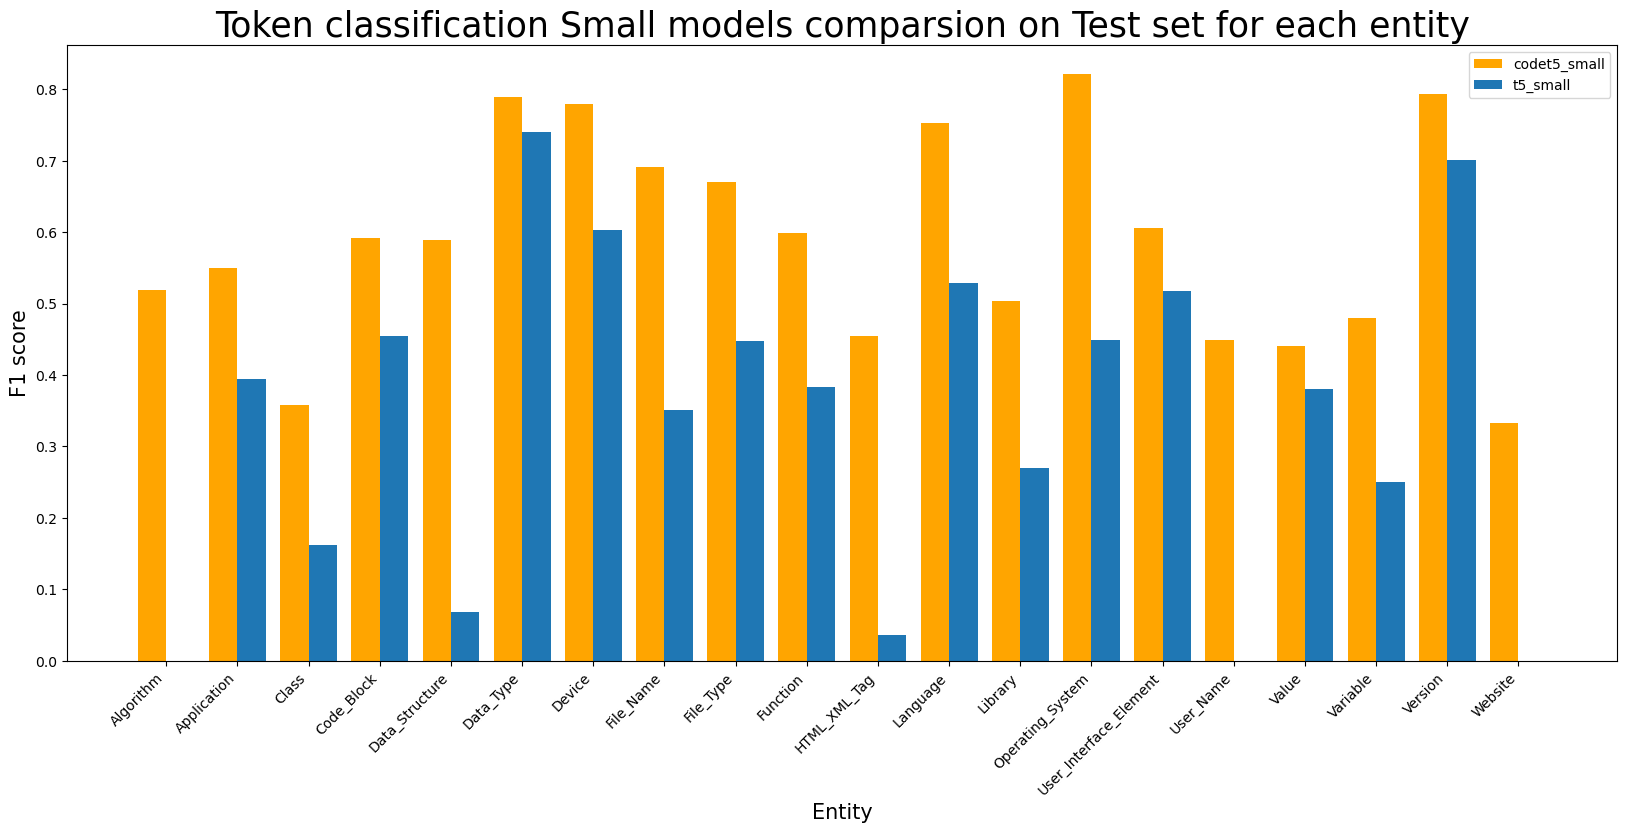

In [12]:
import matplotlib.pyplot as plt

barWidth = 0.2
fig = plt.subplots(figsize =(20, 8))

dct_arr = {x: dct[x]["f1"] for x in dct if "overall" not in x}
dct_arr_code = {x: dct_code[x]["f1"] for x in dct_code if "overall" not in x}

X = [short2long[x] for x in dct_arr.keys()]
X_axis = np.arange(len(X))

plt.bar(X_axis - barWidth, list(dct_arr_code.values()), color="orange", width=barWidth*2, label ='codet5_small')
plt.bar(X_axis + barWidth, list(dct_arr.values()),  width=barWidth*2, label ='t5_small')

plt.title('Token classification Small models comparsion on Test set for each entity', fontsize = 25)
plt.xlabel('Entity', fontsize = 15)
plt.ylabel('F1 score', fontsize = 15) 
plt.xticks(X_axis, X, rotation=45, ha='right')
plt.legend()
plt.savefig(path_save_image + 'plot_small_2.png')
plt.show()


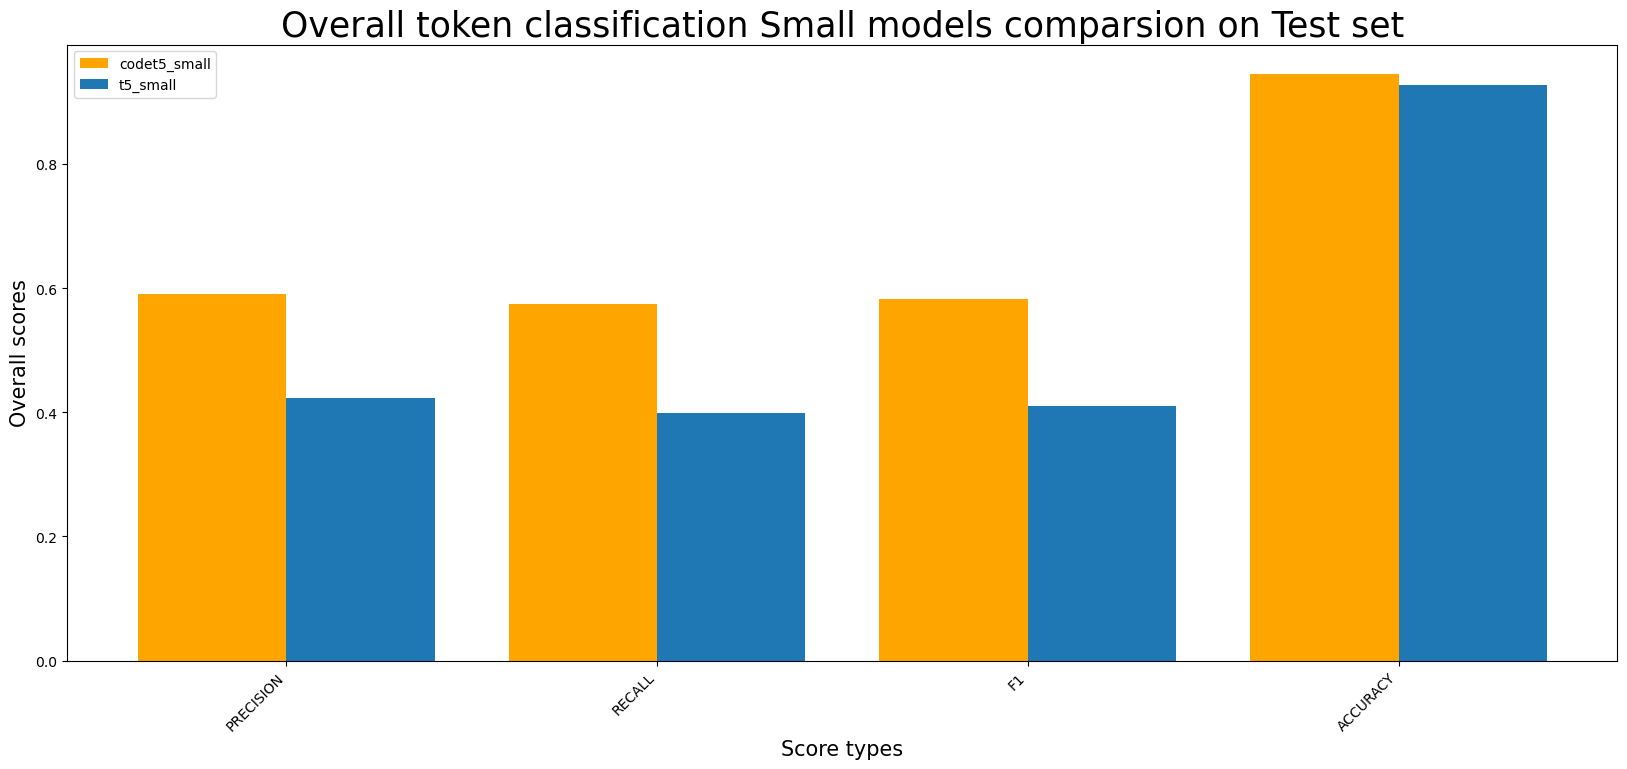

In [13]:
import matplotlib.pyplot as plt

barWidth = 0.2
fig = plt.subplots(figsize =(20, 8))

dct_arr = {x: dct[x] for x in dct if "overall" in x}
dct_arr_code = {x: dct_code[x] for x in dct_code if "overall" in x}

X = [x.split("_")[1].upper() for x in dct_arr.keys() if "overall" in x]
X_axis = np.arange(len(X))

plt.bar(X_axis - barWidth, list(dct_arr_code.values()), color="orange", width=barWidth*2, label="codet5_small")
plt.bar(X_axis + barWidth, list(dct_arr.values()),  width=barWidth*2, label="t5_small")

plt.title('Overall token classification Small models comparsion on Test set', fontsize = 25)
plt.xlabel('Score types', fontsize = 15)
plt.ylabel('Overall scores', fontsize = 15) 
plt.xticks(X_axis, X, rotation=45, ha='right')
plt.legend()
plt.savefig(path_save_image + 'plot_small_3.png')
plt.show()


In [14]:
print(f"F1 scores on TEST set:\n\n{model_name} - {dct['overall_f1']}\n{model_code_name} - {dct_code['overall_f1']}")

F1 scores on TEST set:

t5-small - 0.41054165011256794
Salesforce/codet5-small - 0.5827018552390907


# Domain adaptation

In [15]:
path_gh = "../data/GitHub/"
dataset_gh = load_dataset('json', data_files=os.path.join(path_gh, 'data_gh.json'))

In [16]:
tokenized_dataset_gh = dataset_gh.map(tokenize_and_align_labels, batched=True, fn_kwargs={"tokenizer": tokenizer})
tokenized_dataset_code_gh = dataset_gh.map(tokenize_and_align_labels, batched=True, fn_kwargs={"tokenizer": tokenizer_code})

In [17]:
pred = []
pred_code = []
for item in tokenized_dataset_gh["train"]:
    a = tokenizer(item["tokens"],truncation=True, padding=True,is_split_into_words=True, return_tensors="pt").to("cuda")
    predictions = np.argmax(model(**a).logits.cpu().detach(), axis=2)
    pred.extend(predictions)
    # print(compute_metrics((model(**a).logits.cpu().detach(), tokenized_dataset["test"]["labels"]), full=True))


for item in tokenized_dataset_code_gh["train"]:
    a = tokenizer_code(item["tokens"],truncation=True, padding=True,is_split_into_words=True, return_tensors="pt").to("cuda")
    predictions = np.argmax(model_code(**a).logits.cpu().detach(), axis=2)
    pred_code.extend(predictions)

dct = compute_metrics((pred, tokenized_dataset_gh["train"]["labels"]), True)
dct_code = compute_metrics((pred_code, tokenized_dataset_code_gh["train"]["labels"]), True)

C:\Users\abuboba\.conda\envs\Assignment1_PMLDL\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


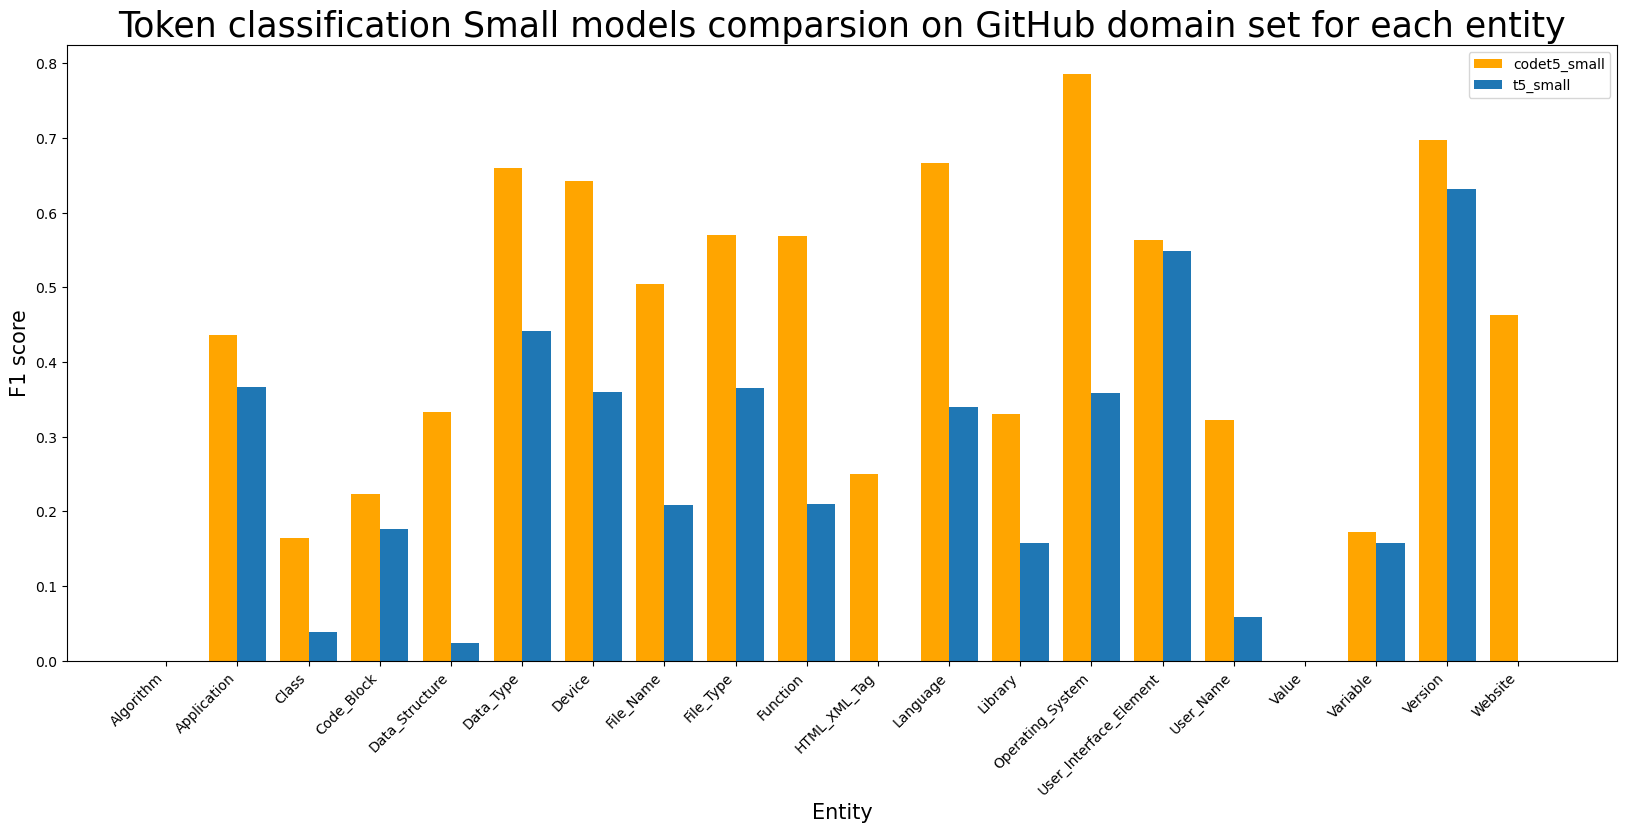

In [18]:
import matplotlib.pyplot as plt

barWidth = 0.2
fig = plt.subplots(figsize =(20, 8))

dct_arr = {x: dct[x]["f1"] for x in dct if "overall" not in x}
dct_arr_code = {x: dct_code[x]["f1"] for x in dct_code if "overall" not in x}

X = [short2long[x] for x in dct_arr.keys()]
X_axis = np.arange(len(X))

plt.bar(X_axis - barWidth, list(dct_arr_code.values()), color="orange", width=barWidth*2, label ='codet5_small')
plt.bar(X_axis + barWidth, list(dct_arr.values()),  width=barWidth*2, label ='t5_small')

plt.title('Token classification Small models comparsion on GitHub domain set for each entity', fontsize = 25)
plt.xlabel('Entity', fontsize = 15)
plt.ylabel('F1 score', fontsize = 15) 
plt.xticks(X_axis, X, rotation=45, ha='right')
plt.legend()
plt.savefig(path_save_image + 'plot_small_4.png')
plt.show()


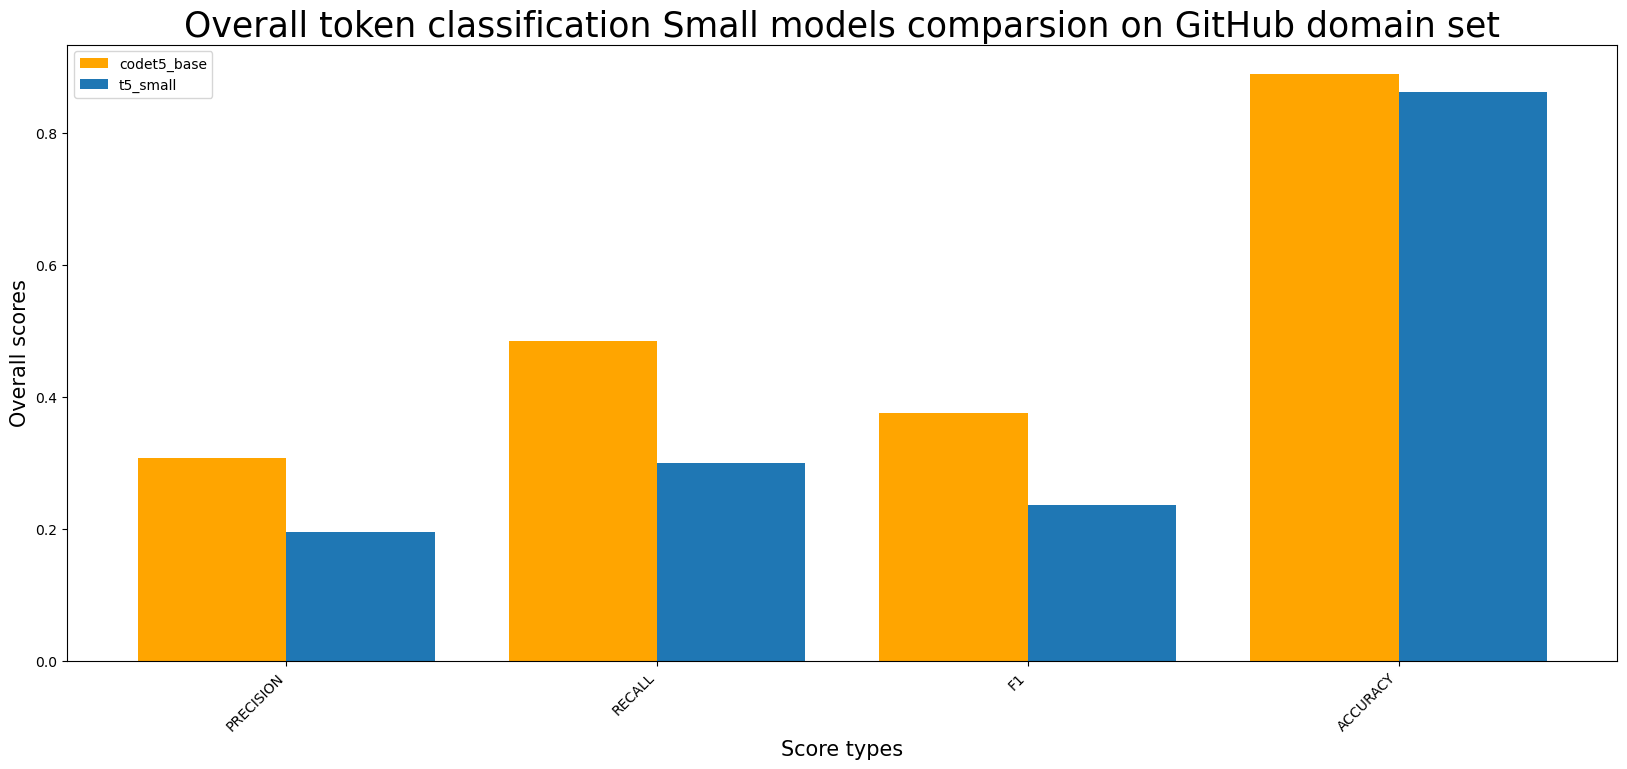

In [19]:
import matplotlib.pyplot as plt

barWidth = 0.2
fig = plt.subplots(figsize =(20, 8))

dct_arr = {x: dct[x] for x in dct if "overall" in x}
dct_arr_code = {x: dct_code[x] for x in dct_code if "overall" in x}

X = [x.split("_")[1].upper() for x in dct_arr.keys() if "overall" in x]
X_axis = np.arange(len(X))

plt.bar(X_axis - barWidth, list(dct_arr_code.values()), color="orange", width=barWidth*2, label="codet5_base")
plt.bar(X_axis + barWidth, list(dct_arr.values()),  width=barWidth*2, label="t5_small")

plt.title('Overall token classification Small models comparsion on GitHub domain set', fontsize = 25)
plt.xlabel('Score types', fontsize = 15)
plt.ylabel('Overall scores', fontsize = 15) 
plt.xticks(X_axis, X, rotation=45, ha='right')
plt.legend()
plt.savefig(path_save_image + 'plot_small_5.png')
plt.show()


In [20]:
print(f"F1 scores on GitHub domain set:\n\n{model_name} - {dct['overall_f1']}\n{model_code_name} - {dct_code['overall_f1']}")

F1 scores on GitHub domain set:

t5-small - 0.2355298308103295
Salesforce/codet5-small - 0.37597949469058956
